## Flight delay data preprocessing and analysis

**1. Data Downloading**

In [65]:
import kagglehub

path = kagglehub.dataset_download("hrishitpatil/flight-data-2024")

print("Downloaded to:", path)


Downloaded to: C:\Users\mwjun\.cache\kagglehub\datasets\hrishitpatil\flight-data-2024\versions\2


In [66]:
from pathlib import Path
import shutil

data_folder = Path('../data')
data_folder.mkdir(exist_ok=True)

for f in Path(path).glob('*'):
    shutil.copy(f, data_folder / f.name)


In [67]:
import pandas as pd

df = pd.read_csv("../data/flight_data_2024.csv")

C:\Users\mwjun\AppData\Local\Temp\ipykernel_1296\1157875057.py:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/flight_data_2024.csv")


In [68]:
df.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


**2. Missing values check**

In [69]:
df.isnull().sum()

year                         0
month                        0
day_of_month                 0
day_of_week                  0
fl_date                      0
op_unique_carrier            0
op_carrier_fl_num            1
origin                       0
origin_city_name             0
origin_state_nm              0
dest                         0
dest_city_name               0
dest_state_nm                0
crs_dep_time                 0
dep_time                 92659
dep_delay                92970
taxi_out                 95734
wheels_off               95734
wheels_on                97856
taxi_in                  97856
crs_arr_time                 0
arr_time                 97854
arr_delay               113814
cancelled                    0
cancellation_code      6982766
diverted                     0
crs_elapsed_time             1
actual_elapsed_time     113814
air_time                113814
distance                     0
carrier_delay                0
weather_delay                0
nas_dela

Note: Cancellation code will be dropped because of major missing values

In [70]:
df = df.drop(columns=["cancellation_code"])
df.columns

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'diverted', 'crs_elapsed_time', 'actual_elapsed_time',
       'air_time', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

Note: dropping rows with missing observations - 110 thousand for 7 million observations is a small number

In [71]:
# before dropping

len(df)

7079081

In [72]:
df = df.dropna()
len(df)

6965266

**3. Noise in data check**

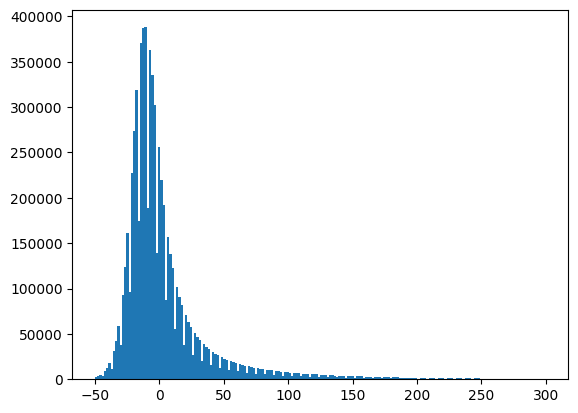

In [73]:
from matplotlib import pyplot as plt

plt.hist(df["arr_delay"], range=(-50, 300), bins=200)
plt.show()

Modelling the relation between arr_delay and dep_delay

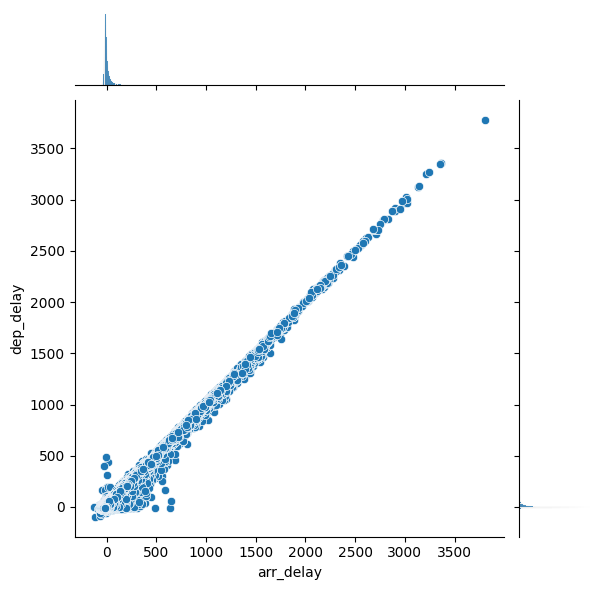

In [74]:
import seaborn as sns

sns.jointplot(df, x="arr_delay", y="dep_delay")

NOTE: Given that the relation between dep_delay and arr_delay stays mostly linear, we can assume that even the largest delays can be used in our models, because they happen in real life and are not simply noise in the data. Dropping them from our dataset could lead to fitting on artificial data.

**4. Duplicate check**

In [75]:
copy_df = df.drop_duplicates()

len(copy_df) - len(df)

0

No duplicates in data

**5. "Logical" data pruning**

In [76]:
def logical_checks(df):
    issues = {}

    issues['year_invalid'] = df[~df['year'].between(1900, 2100)]
    issues['month_invalid'] = df[~df['month'].between(1, 12)]
    issues['day_of_month_invalid'] = df[~df['day_of_month'].between(1, 31)]
    issues['day_of_week_invalid'] = df[~df['day_of_week'].between(1, 7)]

    for col in ['crs_dep_time','dep_time','wheels_off','wheels_on','crs_arr_time','arr_time']:
        issues[f'{col}_invalid'] = df[~df[col].between(0, 2400)]

    for col in ['taxi_out','taxi_in','crs_elapsed_time','actual_elapsed_time','air_time',
                'distance','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']:
        if col == 'distance':
            issues[f'{col}_invalid'] = df[df[col] < 0]
        else:
            issues[f'{col}_invalid'] = df[df[col] < 0]

    issues['cancelled_invalid'] = df[~df['cancelled'].isin([0,1])]
    issues['diverted_invalid'] = df[~df['diverted'].isin([0,1])]

    return {k:v for k,v in issues.items() if not v.empty}

problems = logical_checks(df)
for k, v in problems.items():
    print(k, len(v))

No logical problems found in the dataset

**6. Checking the amount of unique values in each column**

In [77]:
unique_counts = df.nunique()

print(unique_counts)

year                      1
month                    12
day_of_month             31
day_of_week               7
fl_date                 366
op_unique_carrier        15
op_carrier_fl_num      6858
origin                  348
origin_city_name        342
origin_state_nm          52
dest                    348
dest_city_name          342
dest_state_nm            52
crs_dep_time           1360
dep_time               1440
dep_delay              1854
taxi_out                190
wheels_off             1440
wheels_on              1440
taxi_in                 227
crs_arr_time           1429
arr_time               1440
arr_delay              1887
cancelled                 1
diverted                  1
crs_elapsed_time        585
actual_elapsed_time     719
air_time                681
distance               1621
carrier_delay          1632
weather_delay          1116
nas_delay               849
security_delay          195
late_aircraft_delay    1377
dtype: int64


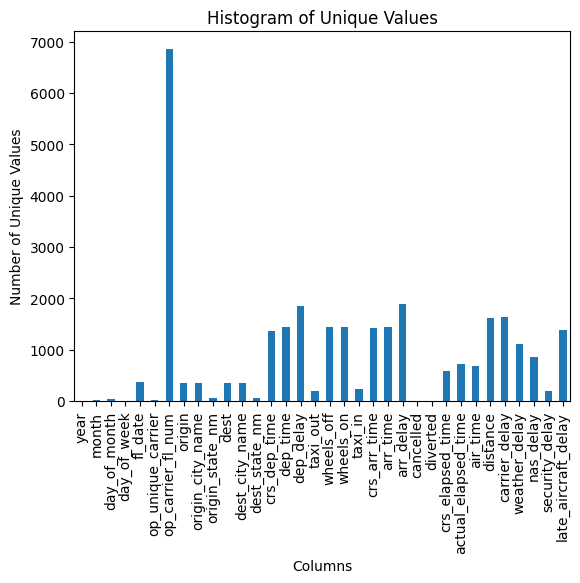

In [78]:
unique_counts.plot(kind='bar', title='Histogram of Unique Values')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.show()

## Adding Columns for classification task purposes

We will assume that in terms of departing a plane is delayed if it's delay is bigger than 15 minutes, beacuse it's the most commonly assumed value.

In terms of arrival delay, we decided that the plane is delayed on arrival if the delay is bigger than 0. We made that assumption beacuse people often take transfer fligths and in that case any delay on arrival can be disastrous for the transfer, so it makes sense to propose such a distinction.

NOTE: In the dataset a delay can be negative if the plane arrives before the scheduled time.

In [79]:
df['is_dep_delayed'] = df['dep_delay'] > 15
df['is_arr_delayed'] = df['arr_delay'] > 0

df[['dep_delay', 'is_dep_delayed', 'arr_delay', 'is_arr_delayed']].head()

,dep_delay,is_dep_delayed,arr_delay,is_arr_delayed
0,-5.0,False,-19.0,False
1,-14.0,False,-30.0,False
2,-4.0,False,-20.0,False
3,-7.0,False,-42.0,False
4,-5.0,False,-14.0,False


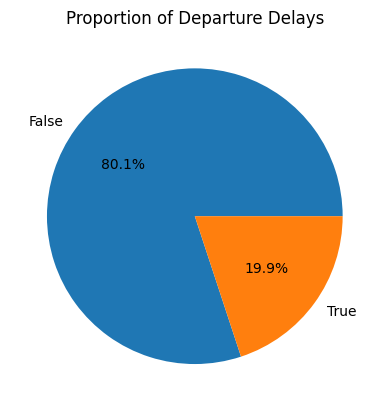

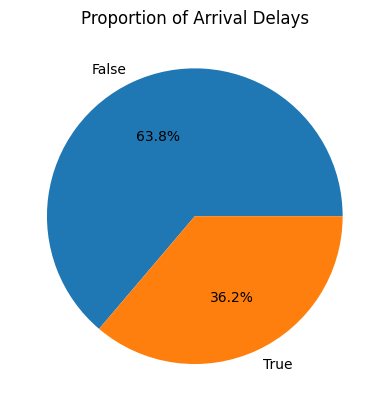

In [80]:
df['is_dep_delayed'].value_counts().plot(kind='pie', title='Proportion of Departure Delays', autopct='%1.1f%%')
plt.ylabel('')
plt.show()

df['is_arr_delayed'].value_counts().plot(kind='pie', title='Proportion of Arrival Delays', autopct='%1.1f%%')
plt.ylabel('')
plt.show()

In [81]:
print("Counts for is_dep_delayed:")
print(df['is_dep_delayed'].value_counts())

print("\nCounts for is_arr_delayed:")
print(df['is_arr_delayed'].value_counts())

Counts for is_dep_delayed:
is_dep_delayed
False    5576380
True     1388886
Name: count, dtype: int64

Counts for is_arr_delayed:
is_arr_delayed
False    4443258
True     2522008
Name: count, dtype: int64


In [82]:
print("Proportion for is_dep_delayed:")
print(df['is_dep_delayed'].value_counts(normalize=True))

print("\nProportion for is_arr_delayed:")
print(df['is_arr_delayed'].value_counts(normalize=True))

Proportion for is_dep_delayed:
is_dep_delayed
False    0.800598
True     0.199402
Name: proportion, dtype: float64

Proportion for is_arr_delayed:
is_arr_delayed
False    0.637916
True     0.362084
Name: proportion, dtype: float64


**Important notice:** the percentage of planes delayed on departure is quite small at about 20 %.For the planes delayed on arrival the class distribution is much better with about 64 % being on time and 36 % being delayed.

**Changing columns that contain data to correct data type**

In [83]:
# fl_date to datetime
df["fl_date"] = pd.to_datetime(df["fl_date"], errors="coerce")
print(df["fl_date"].dtype)
print(df["fl_date"][0])

# crs_dep_time to time
df["crs_dep_time"] = pd.to_datetime(df["crs_dep_time"], format='%H%M', errors="coerce").dt.time
print(df["crs_dep_time"].dtype)
print(df["crs_dep_time"][0])

# dep_time to time
df["dep_time"] = pd.to_datetime(df["dep_time"], format='%H%M', errors="coerce").dt.time
print(df["dep_time"].dtype)
print(df["dep_time"][0])
    
# arr_time to time  
df["arr_time"] = pd.to_datetime(df["arr_time"], format='%H%M', errors="coerce").dt.time
print(df["arr_time"].dtype)
print(df["arr_time"][0])

# crs_arr_time to time
df["crs_arr_time"] = pd.to_datetime(df["crs_arr_time"], format='%H%M', errors="coerce").dt.time
print(df["crs_arr_time"].dtype)
print(df["crs_arr_time"][0])

datetime64[ns]
2024-01-01 00:00:00
object
12:52:00
object
12:47:00
object
14:49:00
object
15:08:00
